In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import swin_s, Swin_S_Weights,SwinTransformer
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.datasets import ImageFolder
from sklearn.model_selection import StratifiedKFold
import numpy as np
from PIL import Image
import os
from itertools import combinations
from torch.optim import lr_scheduler
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [2]:
weights = Swin_S_Weights.DEFAULT
swin_transform = weights.transforms()
dataset_path = './3_levels_folder/'
weight_path = "./swin_s-5e29d889.pth"
saveModel_path='./model/'
if not os.path.exists(saveModel_path):
    os.makedirs(saveModel_path)
batch_size = 32
num_classes=3
epochs=50
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
FolderDataset = ImageFolder(root=dataset_path,transform=swin_transform)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

In [4]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
test_acc_fold={}
for fold, (train_idx, test_idx) in enumerate(skf.split(np.zeros(len(FolderDataset)),
                                                      np.zeros(len(FolderDataset)))):
    print(f"Validation set size for Fold [{fold+1}/5]: {len(test_idx)}")
    best_accuracy=0
    model = swin_s()
    model.load_state_dict(torch.load(weight_path))
    in_features = model.head.in_features
    model.head = nn.Linear(in_features, num_classes)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00001,weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.85)
    train_dataset = Subset(FolderDataset, train_idx)  # 使用train_index创建训练集子集
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataset = Subset(FolderDataset, test_idx)  # 使用test_index创建测试集子集
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    for epoch in range(epochs):
        train_loss = 0.0
        train_acc = 0.0
        # 训练模型
        model.train()  # 设置模型为训练模式
        for batch_x, batch_y in train_dataloader:
            optimizer.zero_grad()
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch_x.size(0)
            _, predict = torch.max(outputs.data, 1)
            train_acc += (predict == batch_y).sum().item()
        train_loss /= len(train_dataloader.dataset)
        train_acc /= len(train_dataloader.dataset)
        scheduler.step()
        print(f"Fold [{fold + 1}/5], Epoch [{epoch + 1}/{epochs}], Loss: {train_loss:.4f},Train Accuracy:{train_acc*100:.4f}%")
        # 在验证集上测试模型
        val_loss = 0.0
        val_acc = 0.0
        model.eval()  # 设置模型为评估模式
        with torch.no_grad():
            for batch_x, batch_y in test_dataloader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item() * batch_x.size(0)
                _, predict = torch.max(outputs.data, 1)
                val_acc += (predict == batch_y).sum().item()
        val_loss /= len(test_dataloader.dataset)
        val_acc /= len(test_dataloader.dataset)
        print(f"Fold [{fold+1}/5], Epoch [{epoch+1}/{epochs}], Loss: {val_loss:.4f}, Validation Accuracy: {val_acc*100:.4f}%")

        if val_acc > best_accuracy:
            best_accuracy = val_acc
            early_stop_counter = 0
            torch.save(model.state_dict(), saveModel_path+f'best_model_{fold+1}.pth')
        else:
            early_stop_counter += 1

        if early_stop_counter >= 10:
            break
    test_acc_fold[fold] = best_accuracy
print(test_acc_fold)

Validation set size for Fold [1/5]: 495
Fold [1/5], Epoch [1/50], Loss: 0.7318,Train Accuracy:71.1684%
Fold [1/5], Epoch [1/50], Loss: 0.6462, Validation Accuracy: 71.7172%
Fold [1/5], Epoch [2/50], Loss: 0.6254,Train Accuracy:73.7987%
Fold [1/5], Epoch [2/50], Loss: 0.5884, Validation Accuracy: 73.9394%
Fold [1/5], Epoch [3/50], Loss: 0.5287,Train Accuracy:78.4016%
Fold [1/5], Epoch [3/50], Loss: 0.5276, Validation Accuracy: 76.9697%
Fold [1/5], Epoch [4/50], Loss: 0.4581,Train Accuracy:82.1447%
Fold [1/5], Epoch [4/50], Loss: 0.5052, Validation Accuracy: 76.9697%
Fold [1/5], Epoch [5/50], Loss: 0.4059,Train Accuracy:84.2185%
Fold [1/5], Epoch [5/50], Loss: 0.5045, Validation Accuracy: 78.5859%
Fold [1/5], Epoch [6/50], Loss: 0.3474,Train Accuracy:86.2418%
Fold [1/5], Epoch [6/50], Loss: 0.5335, Validation Accuracy: 77.7778%
Fold [1/5], Epoch [7/50], Loss: 0.2995,Train Accuracy:88.0627%
Fold [1/5], Epoch [7/50], Loss: 0.5322, Validation Accuracy: 78.7879%
Fold [1/5], Epoch [8/50], Los

Test

In [4]:
label = {0:'destroy',1:"mid_damage",2:"no_damage"}
img_path = './Test/test19.jpg'
model_path = './best/best_model_3.pth'
num_classes=3
weights = Swin_S_Weights.DEFAULT
swin_transform = weights.transforms()

img = Image.open(img_path)
img_tensor = swin_transform(img).unsqueeze(0).cuda()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = swin_s()
in_features = model.head.in_features
model.head = nn.Linear(in_features, num_classes)
model.load_state_dict(torch.load(model_path))
model = model.to(device)

predict = torch.argmax(model(img_tensor),dim=1).data[0]

print(f"The building belongs to class : \"{label[int(predict)]}\" ")

The building belongs to class : "destroy" 


In [34]:
#如果当前路径没有“Error_ID”的文本文件，就创建一个
if not os.path.exists("Error_ID.txt"):
    f = open("Error_ID.txt", "w")
    f.close()
#读取3_level_folder文件夹下的所有文件夹，并用best_model_2.pth进行预测，要求输出预测结果和真实结果
label = {0: 'destroy', 1: "mid_damage", 2: "no_damage"}
dataset_path = './3_levels_folder/'
model_path = './best/best_model_3.pth'
num_classes = 3
weights = Swin_S_Weights.DEFAULT
swin_transform = weights.transforms()
test_dataset = ImageFolder(root=dataset_path, transform=swin_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = swin_s()

in_features = model.head.in_features
model.head = nn.Linear(in_features, num_classes)
model.load_state_dict(torch.load(model_path))

model = model.to(device)
model.eval()
accuracy = 0
error_count = 0
#输出预测结果和真实结果，按照[真实结果，错误结果]的格式输出，并将错误的图片ID写入Error_ID.txt，不修改图片名称
for batch_idx, (data, target) in enumerate(test_loader):
    # Move tensors to GPU if CUDA is available
    data, target = data.to(device), target.to(device)
    # Forward pass
    output = model(data)
    # Calculate the batch loss
    _, pred = torch.max(output, dim=1)
    for i in range(len(target)):
        index_in_dataset = batch_idx * test_loader.batch_size + i
        print(test_loader.dataset.imgs[index_in_dataset][0].split('/')[-1],
            "Pred Res:","destory" if pred[i] == 0 else ("mid_damage" if pred[i] == 1 else "no damage"),
                "Actul Res:", "destory" if target[i] == 0 else ("mid_damage" if target[i] == 1 else "no damage"))
        if pred[i] != target[i]:
            error_count += 1
            #将错误的图片ID写入Error_ID.txt
            f = open("Error_ID.txt", "a")
            f.write(test_loader.dataset.imgs[index_in_dataset][0].split('/')[-1] + "\n")
            f.close()
            print("Error")
    correct_tensor = pred.eq(target.data.view_as(pred))
    accuracy += torch.mean(correct_tensor.type(torch.FloatTensor))
accuracy = accuracy/len(test_loader)
error_rate = error_count/len(test_loader.dataset)
print('Test Accuracy: {:.2f}%'.format(accuracy*100), "Error Rate: {:.2f}%".format(error_rate*100))




destroy_folder\1014.jpg Pred Res: destory Actul Res: destory
destroy_folder\1017.jpg Pred Res: destory Actul Res: destory
destroy_folder\1018.jpg Pred Res: destory Actul Res: destory
destroy_folder\1024.jpg Pred Res: destory Actul Res: destory
destroy_folder\1029.jpg Pred Res: destory Actul Res: destory
destroy_folder\1037.jpg Pred Res: destory Actul Res: destory
destroy_folder\1053.jpg Pred Res: destory Actul Res: destory
destroy_folder\1054.jpg Pred Res: destory Actul Res: destory
destroy_folder\1057.jpg Pred Res: destory Actul Res: destory
destroy_folder\1060.jpg Pred Res: destory Actul Res: destory
destroy_folder\1120.jpg Pred Res: destory Actul Res: destory
destroy_folder\1131.jpg Pred Res: destory Actul Res: destory
destroy_folder\1135.jpg Pred Res: destory Actul Res: destory
destroy_folder\118.jpg Pred Res: destory Actul Res: destory
destroy_folder\1189.jpg Pred Res: destory Actul Res: destory
destroy_folder\1191.jpg Pred Res: destory Actul Res: destory
destroy_folder\1196.jpg P

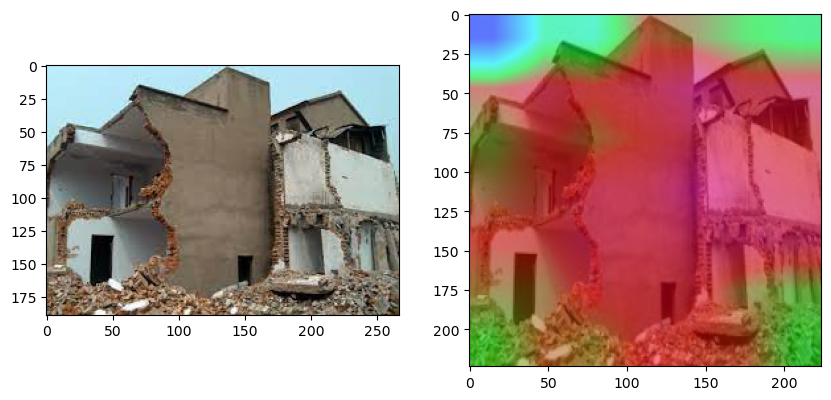

In [5]:
import cv2
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Define Grad-CAM
class GradCAM:
    def __init__(self, model, layer_name):
        self.model = model
        self.layer_name = layer_name
        self.target_layer = dict([*self.model.named_modules()])[layer_name]
        self.gradients = None
        self.target_value = None  # Added
        self.target_layer.register_forward_hook(self.save_gradient)
        self.target_layer.register_forward_hook(self.save_value)  # Added

    def save_gradient(self, module, input, output):
        self.gradients = output

    def save_value(self, module, input, output):  # Added
        self.target_value = output

    def __call__(self, inputs, index=None):
        outputs = self.model(inputs)
        if index is None:
            index = torch.argmax(outputs, 1)
        one_hot = torch.zeros((1, outputs.size()[-1]), dtype=torch.float32).to(inputs.device)
        one_hot[0][index] = 1
        one_hot = one_hot.requires_grad_()
        one_hot = torch.sum(one_hot * outputs)
        one_hot.backward(retain_graph=True)
        grad_values = self.gradients[0].cpu().data.numpy()
        target = self.target_value[0].cpu().data.numpy()  # Modified
        weights = np.mean(grad_values, axis=(1, 2))
        cam = np.zeros(target.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * target[i, :, :]
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (224, 224))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

class DamgeScore:
    def __init__(self, model, layer_name):
        self.grad_cam = GradCAM(model, layer_name)

    def score(self, image_tensor):
        cam = self.grad_cam(image_tensor)
        damge_score = np.mean(cam)
        return damge_score

def visualize(image_path, cam):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))  # resize the image to (224,224,3)
    img = np.float32(img) / 255
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_RAINBOW)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

num_classes = 3
model_path = './best/best_model_3.pth'
#model_path= './swin_s-5e29d889.pth'
weights = Swin_S_Weights.DEFAULT
swin_transform = weights.transforms()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = swin_s()

in_features = model.head.in_features
model.head = nn.Linear(in_features, num_classes)
model.load_state_dict(torch.load(model_path))

model = model.to(device)
model.eval()
image_path = './Test/test18.jpg'
img = Image.open(image_path)
img_tensor = swin_transform(img).unsqueeze(0).cuda()
damge_score = DamgeScore(model, 'permute')
grad_cam = GradCAM(model, 'permute')
damge_score.score(img_tensor)
cam = grad_cam(img_tensor)
cam = visualize(image_path, cam)
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(cam)
plt.show()


